## 使用keras构建LSTM模型
__author__ = 'hehuihui@caicloud.io'

In [1]:
import numpy as np
import pandas as pd

from keras.models import Sequential, Input
from keras.layers import Dense, LSTM, Dropout, BatchNormalization
from sklearn.preprocessing import StandardScaler, MinMaxScaler

Using TensorFlow backend.


## 1. 数据读取

In [2]:
input_file = '../data/000002-万科A.csv'

df = pd.read_csv(input_file)
dataset = df.loc[:, 'open':'volume'].values  # 取从open到volume共5列的数据值
#print df.head()

## 2. 训练集和测试集划分

In [3]:
def split_train_test(dataset, split_ratio=0.8):
    ''' 划分训练集和测试集
    # Args
        dataset: np.ndarray, 待划分的数据集
        split_ratio: float, 训练集所占比例
    # Returns
        X_train, Y_train: np.ndarray, 训练集中的特征和标签
        X_test, Y_test: np.ndarray, 测试集中的特征和标签
    '''
    N = int(len(dataset) * split_ratio) # 训练集与测试集的分界点
    
    X_train = dataset[:N, :]
    Y_train = dataset[:N, 1].reshape(-1, 1) #以收盘价为标签，并将维度从(?)扩展为(?, 1)
    
    X_test = dataset[N:, :]
    Y_test = dataset[N:, 1].reshape(-1, 1)
    return X_train, Y_train, X_test, Y_test

X_train, Y_train, X_test, Y_test = split_train_test(dataset, split_ratio=0.8)
#print X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

## 3. 数据归一化

In [4]:
def scale_dataset(train_set, test_set):
    ''' 对数据集做归一化处理
    # Args:
        train_set: np.ndarray, 训练集
        test_set: np.ndarray, 测试集
    # Returns:
        scaler: MinMaxScaler, 归一化处理器
        train_set: np.ndarray, 归一化后的训练集
        test_set: np.ndarray, 归一化后的测试集
    '''
    scaler = MinMaxScaler()
    scaler.fit(train_set) # 注意：为防止用到未来数据，此处只能使用训练集来生成归一化处理器
    
    train_set = scaler.transform(train_set) # 训练集归一化
    test_set = scaler.transform(test_set)   # 测试集归一化
    
    return scaler, train_set, test_set

X_scaler, X_train, X_test = scale_dataset(X_train, X_test)
Y_scaler, Y_train, Y_test = scale_dataset(Y_train, Y_test)


## 4. LSTM数据集生成

In [5]:
def create_LSTM_dataset(X, Y, time_steps=20):
    ''' 生成LSTM训练所需的数据集格式
    # Args
        X: np.2D-array, 特征矩阵
        Y: np.2D-array, 标签矩阵
        time_steps: int, 使用多少天的数据作为特征
    # Returns:
        X_dataset, y_dataset: (np.3D-array, np.2D-array)，特征数据集、标签数据集
    '''
    X_list, Y_list = [], []
    assert(len(X) == len(Y))
    for i in range(len(X) - time_steps - 1):
        X_list.append(X[i:(i + time_steps), :])
        Y_list.append(Y[(i + 1):(i + time_steps + 1), :])
    return np.array(X_list), np.squeeze(Y_list)

train_X, train_y = create_LSTM_dataset(X_train, Y_train)
test_X, test_y = create_LSTM_dataset(X_test, Y_test)

#print train_X.shape, train_y.shape, test_X.shape, test_y.shape

## 5. LSTM模型定义（使用keras）

In [6]:
def build_LSTM_model(time_steps=20, feature_dim=5):
    model = Sequential()
    model.add(LSTM(128, input_shape=(time_steps, feature_dim), dropout=0.8))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(time_steps, activation='relu'))
    
    model.compile(optimizer='sgd', loss='mse', metrics=['mae'])
    return model

model = build_LSTM_model(20)
#print(model.summary())

## 6. LSTM模型训练

In [7]:
history = model.fit(train_X, train_y, 
                    epochs=20, verbose=2, batch_size=16, shuffle=False, 
                    validation_data=(test_X, test_y))

Train on 831 samples, validate on 193 samples
Epoch 1/20
4s - loss: 0.0868 - mean_absolute_error: 0.2161 - val_loss: 0.5050 - val_mean_absolute_error: 0.6999
Epoch 2/20
3s - loss: 0.0819 - mean_absolute_error: 0.2043 - val_loss: 0.4841 - val_mean_absolute_error: 0.6839
Epoch 3/20
3s - loss: 0.0777 - mean_absolute_error: 0.1949 - val_loss: 0.4639 - val_mean_absolute_error: 0.6678
Epoch 4/20
3s - loss: 0.0754 - mean_absolute_error: 0.1892 - val_loss: 0.4439 - val_mean_absolute_error: 0.6516
Epoch 5/20
3s - loss: 0.0721 - mean_absolute_error: 0.1837 - val_loss: 0.4247 - val_mean_absolute_error: 0.6360
Epoch 6/20
3s - loss: 0.0688 - mean_absolute_error: 0.1783 - val_loss: 0.4067 - val_mean_absolute_error: 0.6211
Epoch 7/20
3s - loss: 0.0674 - mean_absolute_error: 0.1754 - val_loss: 0.3905 - val_mean_absolute_error: 0.6075
Epoch 8/20
3s - loss: 0.0647 - mean_absolute_error: 0.1720 - val_loss: 0.3750 - val_mean_absolute_error: 0.5946
Epoch 9/20
3s - loss: 0.0642 - mean_absolute_error: 0.1712

## 7. 训练误差可视化

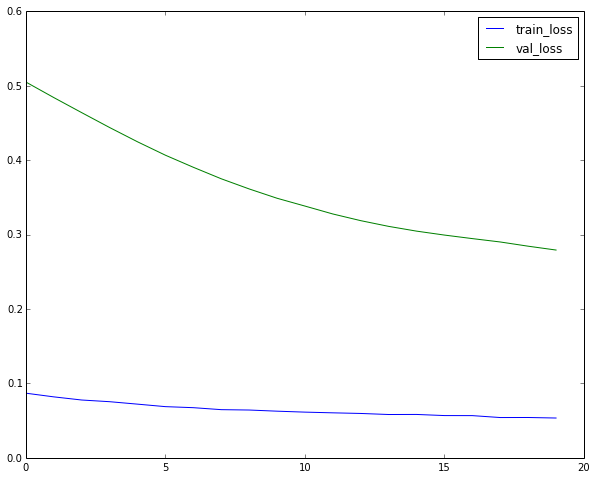

In [8]:
%matplotlib inline
import matplotlib.pyplot as plot

plot.figure(figsize=(10, 8))
plot.plot(history.history['loss'], label='train_loss')
plot.plot(history.history['val_loss'], label='val_loss')
plot.legend()
plot.show()

# TODO：
### 特征工程
### 模型参数调优
### 模型评估与模型预测
### 数据可视化